- Ana Sofía Escobar - 20489
- Wilfredo Gallegos
- Stefan Quintana
- Jorge Caballeros

# Proyecto Final - Mineria de datos

In [67]:
import pandas as pd
import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import optimizers
 
plt.style.use('ggplot')

In [68]:
# Cargar los datos
muertes = pd.read_csv('final.csv')
# Quitar causa de muerte y edad ya que es información no necesaria
muertes = muertes.loc[:, muertes.columns != 'Perdif']
muertes = muertes.loc[:, muertes.columns != 'caudef.descrip']

C:\Users\anaso\AppData\Local\Temp\ipykernel_5936\3553369772.py:2: DtypeWarning: Columns (7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  muertes = pd.read_csv('final.csv')


In [69]:
muertes['cause'] = muertes['Caudef'].copy()
repl = {r'([AB])(\d+.*)' : r'AB', r'(C)(\d+.*)' : r'CD',  r'(D[0-4])(\d+.*)' : r'CD', r'(D[5-8])(\d+.*)' : r'DD', r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF', r'(G)(\d+.*)' : r'GG', r'(H[0-5])(\d+.*)' : r'HA', r'(H[6-9])(\d+.*)' : r'HB', r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ', r'(K)(\d+.*)' : r'KK', r'(L)(\d+.*)' : r'LL', r'(M)(\d+.*)' : r'MM', r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO', r'(P)(\d+.*)' : r'PP', r'(Q)(\d+.*)' : r'QQ', r'(R)(\d+.*)' : r'RR', r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY', r'([Z])(\d+.*)' : r'ZZ', r'([U])(\d+.*)' : r'UU',
        }
muertes.cause = muertes['cause'].replace(repl, regex=True)
muertes['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

In [70]:
# Eliminación de toda la información personal
sample = muertes.drop(['Areag', 'Depreg', 'Mupreg', 'Mesreg', 'Añoreg','Mupocu',
                      'Edadif','Puedif','Ecidif','Escodif','Ciuodif','Pnadif','Dnadif',
                      'Mnadif', 'Nacdif', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Caudef'], axis=1)

In [71]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
sample = sample.groupby(by=['cause','Depocu', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur', 'Cerdef']).count()
sample.columns = ['number_deaths']

In [72]:
# Nuevo conjunto de datos
sample = sample.reset_index(level=['cause', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur','Cerdef','Depocu'])

<AxesSubplot: xlabel='number_deaths', ylabel='Count'>

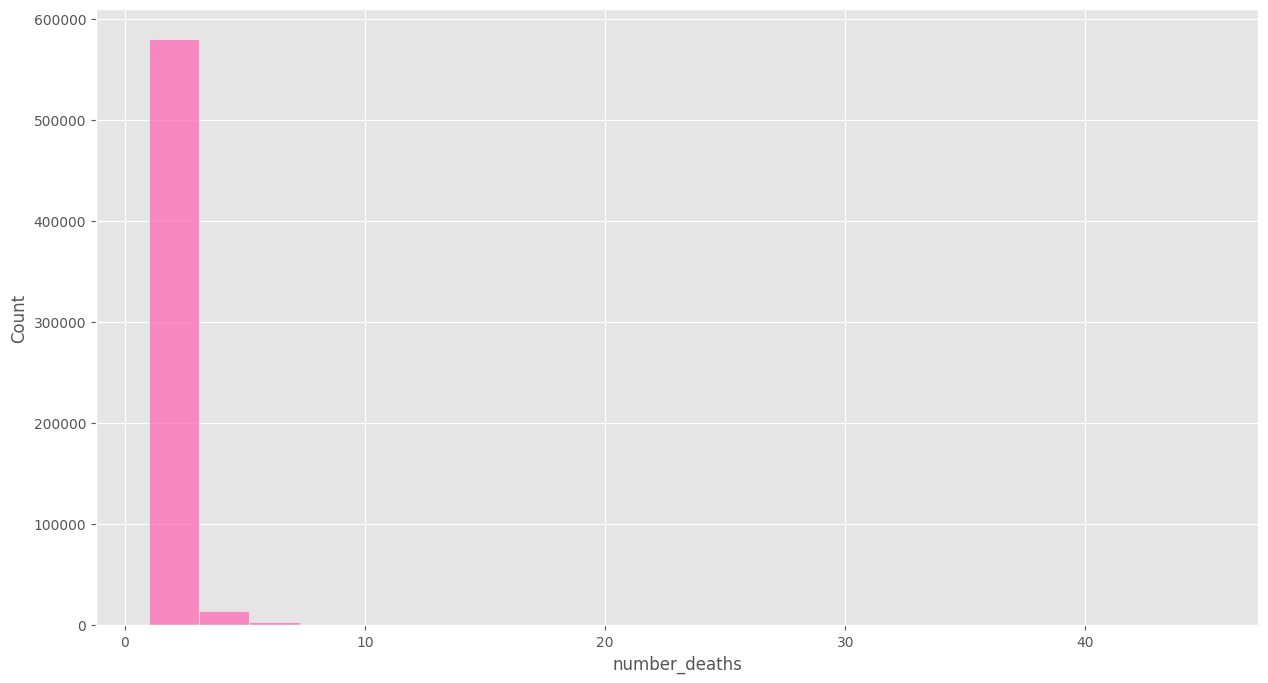

In [73]:
#Gráfica de la distribución de la variable objetivo
plt.figure(figsize=(15, 8))
sns.histplot(sample.number_deaths, color = 'hotpink')

In [74]:
# Evaluar la correlación de las variables
for column in sample.columns:
  if column != 'cause':
    crosstable = pd.crosstab(sample[column], sample['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

cause             AB     CD    DD     EE    FF    GG  HA  HB     II     JJ  \
Depocu                                                                       
Alta Verapaz    4589   3018   934   4106   116   682   6   4   4335   6433   
Baja Verapaz     499   1284    57    951    51   203   3   0   2480   1547   
Chimaltenango    830   2565   175   2368   417   348   0   0   3579   3630   
Chiquimula       742   1836   146   1445    71   352   0   0   3790   2334   
El Progreso      171   1187    26    873    35   146   0   0   2286    782   
Escuintla       1834   3357   554   4522   180   798   0   3   5500   3612   
Guatemala       6614  13306  1774  12850  1247  4004   5   7  15722  11156   
Huehuetenango   2867   4038   265   3364   251   903   1   5   5281   5319   
Izabal          1127   1518   166   1574    48   318   0   1   3293   1411   
Jalapa           671   1516    74    948    49   487   0   0   2646   1728   
Jutiapa          521   2740   130   2073   112   369   1   0   5

In [75]:
# Eliminando las variables correlacionadas
sample = sample.drop(['Asist', 'Diaocu', 'Cerdef'], axis=1)

In [76]:
# Agrupando nuevamente
sample = sample.groupby(['cause', 'Ocur','Depocu', 'Añoocu', 'Mesocu']).count()
sample = sample.reset_index(level=['cause', 'Ocur','Depocu', 'Añoocu', 'Mesocu'])

0        1
1        1
2        1
3        1
4        1
        ..
93232    3
93233    3
93234    2
93235    3
93236    3
Name: number_deaths, Length: 93237, dtype: int64

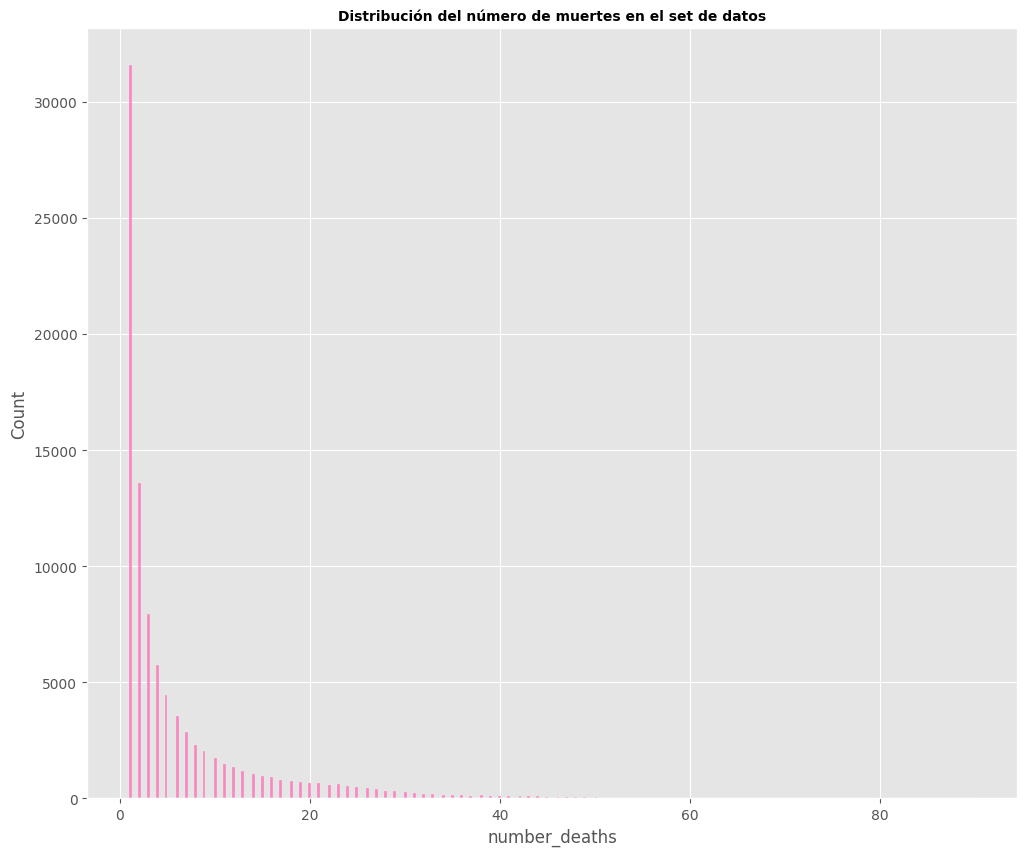

In [77]:
plt.figure(figsize=(12, 10))
sns.histplot(sample.number_deaths, color = 'hotpink')
plt.title('Distribución del número de muertes en el set de datos', fontsize = 10, fontweight = "bold")
sample.number_deaths

In [78]:
# Codificación de las variables
codificacion = OrdinalEncoder(dtype=int)
for column in sample.columns:
        if column != 'number_deaths':
                sample[column] = codificacion.fit_transform(sample[[column]])
                print(codificacion.categories_)

[array(['AB', 'CD', 'DD', 'EE', 'FF', 'GG', 'HA', 'HB', 'II', 'JJ', 'KK',
       'LL', 'MM', 'NN', 'OO', 'PP', 'QQ', 'RR', 'UU', 'VY'], dtype=object)]
[array(['Centro de salud', 'Domicilio', 'Hospital privado',
       'Hospital público', 'Ignorado', 'Lugar de trabajo', 'Otro',
       'Seguro social', 'Vía pública'], dtype=object)]
[array(['Alta Verapaz', 'Baja Verapaz', 'Chimaltenango', 'Chiquimula',
       'El Progreso', 'Escuintla', 'Guatemala', 'Huehuetenango', 'Izabal',
       'Jalapa', 'Jutiapa', 'Peten', 'Petén', 'Quetzaltenango', 'Quiche',
       'Quiché', 'Retalhuleu', 'Sacatepequez', 'Sacatepéquez',
       'San Marcos', 'Santa Rosa', 'Solola', 'Sololá', 'Suchitepequez',
       'Totonicapan', 'Totonicapán', 'Zacapa'], dtype=object)]
[array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)]
[array(['Abril', 'Agosto', 'Diciembre', 'Enero', 'Febrero', 'Julio',
       'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'],
      dtype=object)

In [79]:
# Variables  predecir
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
# Conjuntos de entrenamiento y prueba
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.33,
                                                                                stratify=predictors['cause'], random_state=190243)

# Redes neuronales

In [ ]:
predictors

In [ ]:
#Forma de los datos
print('Train')
print('Predictors: ', predictors_train.shape, 'Target:', target_train.shape)
print('Test')
print('Predictors: ', predictors_test.shape, 'Target:', target_test.shape)

sample_shape = predictors_train.shape[1:]
print('Data shape:', sample_shape)

In [ ]:
# Creación del modelo de red neuronal
# Capas de la red
def create_network():
    input = Input(shape=sample_shape, name='input')
    process = Dense(64, activation='relu', name='dense2')(input)
    process = Dense(16, activation='relu', name='dense3')(process)
    dropout = Dropout(0.15, name='dropout')(process)
    process = Dense(8, activation='relu', name='dense4')(process)
    process = Dense(1, activation=None, name='regressor')(process)
    # Creación del modelo
    nn_model = Model(input, process, name='Number_deaths')

    # Compilando el modelo
    optimizer = optimizers.Adam(learning_rate=1e-4, epsilon=1e-6)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return nn_model

In [ ]:
modelo1 = create_network()
# Entrenamiento de las redes
history = modelo1.fit(predictors_train, target_train, epochs=40, batch_size=128, validation_split=0.15)

In [ ]:
#Grafico de comparacion entre el objetivo y la prediccion
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

#Gráfico de precisión
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['mae']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_mae']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'mean squared error', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
#Predicciones
prediction = modelo1.predict(predictors_test)
prediction = np.squeeze(prediction)

In [ ]:
results = pd.DataFrame({
    'Predicción': prediction,
    'Real': target_test
})

print ("Varianza:",explained_variance_score(target_test, prediction))
print ("Mean absolute Error:", mean_absolute_error(target_test, prediction))
print ("Mean squared error:", mean_squared_error(target_test, prediction))

results.tail(10)